# Nguyen Vinh Nghi 

# CE182108

In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [144]:
def draw_img(image, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title(title)

    plt.show()

# Function 1

In [145]:
def find_harris_corners(input_img, threshold):
    
    corner_list = []
    output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)
    
    offset = 2
    k = 0.04

    y_range = input_img.shape[0] - offset
    x_range = input_img.shape[1] - offset
    
    
    dy, dx = np.gradient(input_img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            
            #Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1
            
            #The variable names are representative to 
            #the variable of the Harris corner equation
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            
            #Sum of squares of intensities of partial derevatives 
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Calculate determinant and trace of the matrix
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            
            #Calculate r for Harris Corner equation
            r = det - k*(trace**2)

            if r > threshold:
                corner_list.append([x, y, r])
                # output_img[y,x] = (255,0,0)
                
                #increase dot size for easy look
                cv2.circle(
                    output_img, 
                    (x, y), 
                    radius=2, 
                    color=(255, 0, 0), 
                    thickness=-1
                )
            
    return output_img 

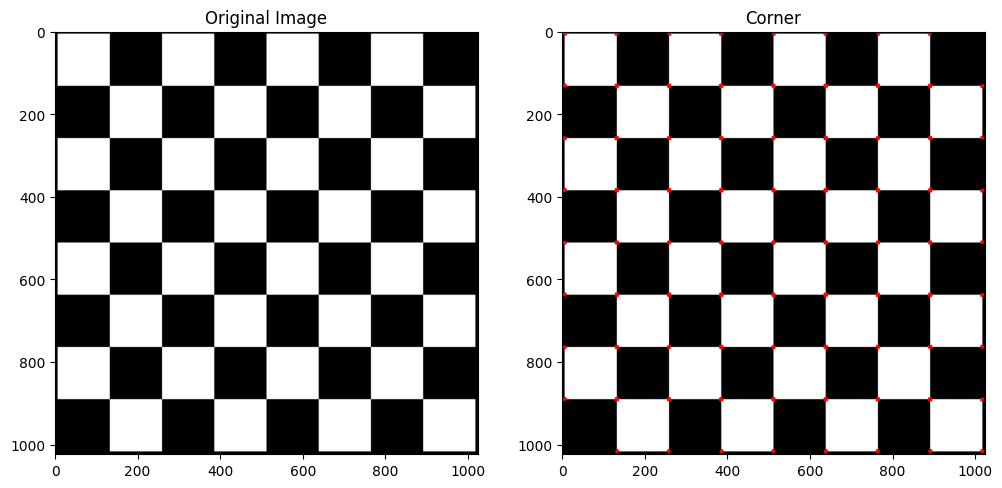

In [146]:
img_path = "./Chess_Board.png"
threshold = 10000.00
    
img = cv2.imread(img_path, 0)

cv2.waitKey(0)
if img is not None:
    corner_img = find_harris_corners(img, threshold)
    
    if corner_img is not None:
        draw_img(corner_img, "Corner")
else:
    print ("Error in input image!")

# Fuction 2

In [147]:
img = cv2.imread('./popularImage.png') # or cv2.IMREAD_GRAYSCALE, 'chess.png'
assert img is not None, "file could not be read, check with os.path.exists()"
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[3:307, 3:307]
print(img_gray.shape)


(304, 304)


In [148]:
# Compute gradient of an image by rows and columns
dx, dy = np.gradient(img_gray)
magnitude_gradient = np.sqrt(dy**2 + dx**2)
orientation_gradient = abs(np.rad2deg(np.arctan2(dy, dx))) # * 180/np.pi
# print(orientation_gradient)

bins = np.arange(0, 180, 20)
print(bins)
# [ 0  20  40  60  80 100 120 140 160]

[  0  20  40  60  80 100 120 140 160]


In [149]:
def hog_cell(cell_mag, cell_dir, bins=[0, 20, 40, 60, 80, 100, 120, 140, 160]):
    """
        magnitude of each orientation is distributed to bins using interpolation algorithm
    """

    cell_hist = np.zeros(len(bins))
    last_bin_idx = len(bins) - 1
    mags = cell_mag.flatten()
    dirs = cell_dir.flatten()
    # print(mags)
    # print(dirs)

    for i in range(len(dirs)):
        for b in range(len(bins)):
            # print(b)
            if (dirs[i] > bins[b] and b == len(bins)-1):
                cell_hist[8] += mags[i] - (dirs[i]-bins[last_bin_idx])/(180 - bins[last_bin_idx])*mags[i]
                cell_hist[0] += (dirs[i]-bins[last_bin_idx])/(180-bins[last_bin_idx])*mags[i] 
                # print("over 140", cell_hist)
            else:
                # print(bins[b+1])
                if(dirs[i]>bins[b] and dirs[i] <= bins[b+1]):
                    cell_hist[b] += (bins[b+1] - dirs[i]) / (bins[b+1] - bins[b])*mags[i]
                    cell_hist[b+1] += (dirs[i] - bins[b]) / (bins[b+1] - bins[b])*mags[i]
                        
    # print(cell_hist)
    return cell_hist


In [150]:
# for testing
cell_mag = np.array([[1, 2], [3, 4]])
cell_dir = np.array([[-125, 85], [150, 4]])

cell_hist = hog_cell(cell_mag, cell_dir)
print(cell_hist, type(cell_hist))

[3.2 0.8 0.  0.  1.5 0.5 0.  1.5 1.5] <class 'numpy.ndarray'>


In [151]:
def hist_of_oriented_gradient(img_gray, window_size=16, cell_size=4):
    """
    In this example, window size (patch size) and cell size are given as default.
    If lecturer wants to change these values, remember to resize the image to a suitable size.
    """

    dy, dx = np.gradient(img_gray)
    # print(dy.shape)

    magnitude_gradient = np.sqrt(dy**2 + dx**2)
    # print(magnitude_gradient.shape)

    orientation_gradient = abs(np.rad2deg(np.arctan2(dy, dx))) # 180/np.pi
    yRange = img_gray.shape[0] // window_size
    xRange = img_gray.shape[1] // window_size
    # print("yRange, xRange = ", yRange, xRange)
    
    img_hist = np.array([])
    for y in range(yRange):
        for x in range(xRange):
            window = img_gray[(y*window_size): ((y+1)*window_size), 
                              (x*window_size): ((x+1)*window_size)]
            window_magnitude_gradient = magnitude_gradient[(y*window_size): ((y+1)*window_size), 
                                                           (x*window_size): ((x+1)*window_size)]
            window_orientation_gradient = orientation_gradient[(y*window_size): ((y+1)*window_size), 
                                                               (x*window_size): ((x+1)*window_size)]
            # if(y==yRange-1 and x==xRange-1): print(window_orientation_gradient.shape)
            window_hist = np.array([])
            iRange = int(np.sqrt(window_size/cell_size))
            for i in range(iRange):
                for j in range(iRange):
                    # if(y==0 and x==0): print("i, j = ", i, j)
                    cell_mag = window_magnitude_gradient[(i*cell_size): ((i+1)*cell_size),
                                                         (j*cell_size): ((j+1)*cell_size)]
                    cell_dir = window_orientation_gradient[(i*cell_size): ((i+1)*cell_size), 
                                                           (j*cell_size): ((j+1)*cell_size)]
                    cell_hist = hog_cell(cell_mag, cell_dir)
                    # if(y==0 and x==0): print("cell_hist.shape = ", cell_hist.shape)
                    window_hist = np.hstack((window_hist, cell_hist))
                    # if(y==0 and x==0): print("cell_hist shape, window_hist.shape = ", cell_hist.shape, window_hist.shape)
            img_hist = np.hstack((img_hist, window_hist))

    return img_hist.reshape(yRange*xRange, 36)

# Testing the function
hog_fratures = hist_of_oriented_gradient(img_gray)
print("hog_fratures = ", hog_fratures.shape)
# draw_img(hog_fratures,"res")


hog_fratures =  (361, 36)


# Function 3

In [152]:
def Canny_detector(img, weak_th = None, strong_th = None): 
    # Noise reduction step 
    img = cv2.GaussianBlur(img, (5, 5), 1.4) 
       
    # Calculating the gradients 
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3) 
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3) 
      
    # Conversion of Cartesian coordinates to polar  
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 
       
    # setting the minimum and maximum thresholds  
    mag_max = np.max(mag) 
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
    height, width = img.shape 
       
    for i_x in range(width): 
        for i_y in range(height): 
               
            grad_ang = ang[i_y, i_x] 
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang) 
               
            # selecting the neighbours of the target pixel 
            # according to the gradient direction 
           
            if grad_ang<= 22.5: 
                neighb_1_x, neighb_1_y = i_x-1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y 
              
            # top right (diagonal-1) direction 
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45): 
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction 
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90): 
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagonal-2) direction 
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135): 
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Restarts the cycle 
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180): 
                neighb_1_x, neighb_1_y = i_x-1, i_y 
                neighb_2_x, neighb_2_y = i_x + 1, i_y 
               
            # Non-maximum suppression 
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0: 
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]: 
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0: 
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]: 
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img) 
    strong_ids = np.zeros_like(img)               
    ids = np.zeros_like(img) 
       
    # double thresholding  
    for i_x in range(width): 
        for i_y in range(height): 
              
            grad_mag = mag[i_y, i_x] 
              
            if grad_mag<weak_th: 
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th: 
                ids[i_y, i_x]= 1
            else: 
                ids[i_y, i_x]= 2
       
    return mag 

In [153]:
canny_img = Canny_detector(img_gray, 50, 150) 
edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

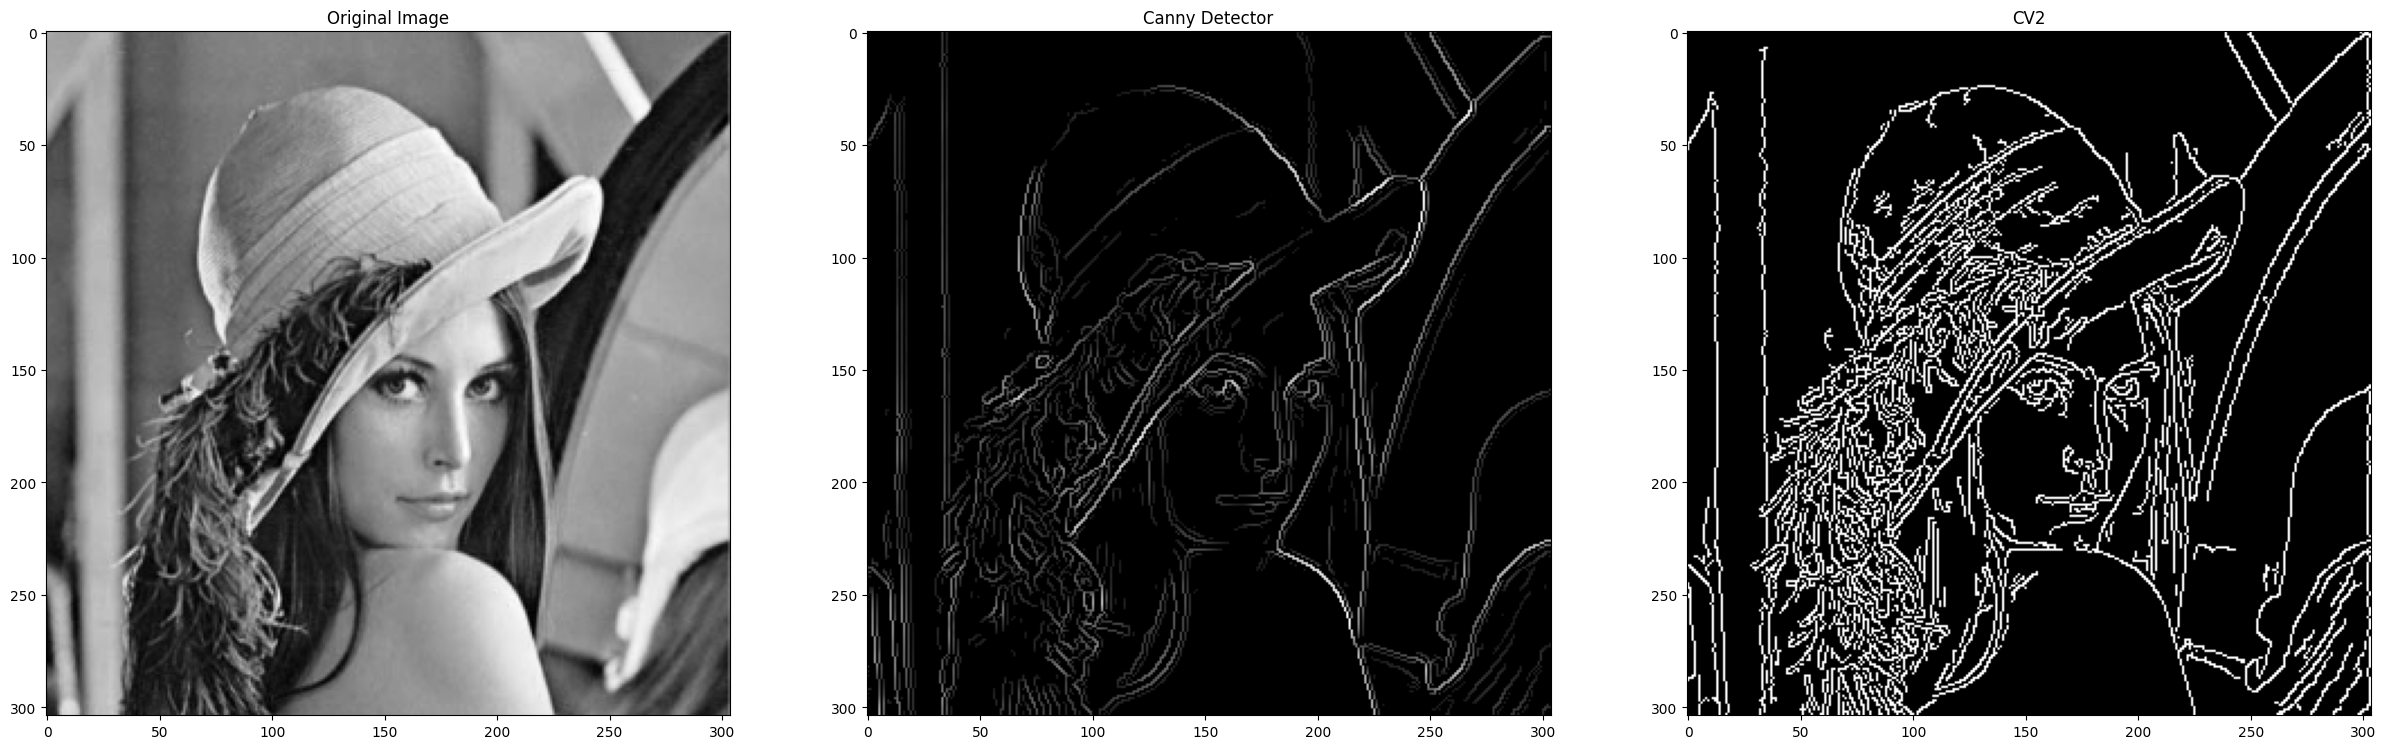

In [154]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(canny_img, cmap='gray')
plt.title('Canny Detector')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('CV2')

plt.show()

# Function 4

In [155]:
def houghLine(image):
    # Get image dimensions
    # y for rows and x for columns
    Ny = image.shape[0]
    Nx = image.shape[1]

    # Max distance is diagonal one
    Maxdist = int(np.round(np.sqrt(Nx**2 + Ny**2)))

    # Theta in range from -90 to 90 degrees
    thetas = np.deg2rad(np.arange(-90, 90))

    # Range of radius
    rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
    accumulator = np.zeros((2 * Maxdist, len(thetas)))

    for y in range(Ny):
        for x in range(Nx):
            # Check if it is an edge pixel
            if image[y,x] > 0:
                # Map edge pixel to hough space
                for k in range(len(thetas)):
                    # Calculate space parameter
                    r = int(x*np.cos(thetas[k]) + y*np.sin(thetas[k]))
                    # Update the accumulator
                    accumulator[int(r) + Maxdist, k] += 1

    return accumulator, thetas, rs


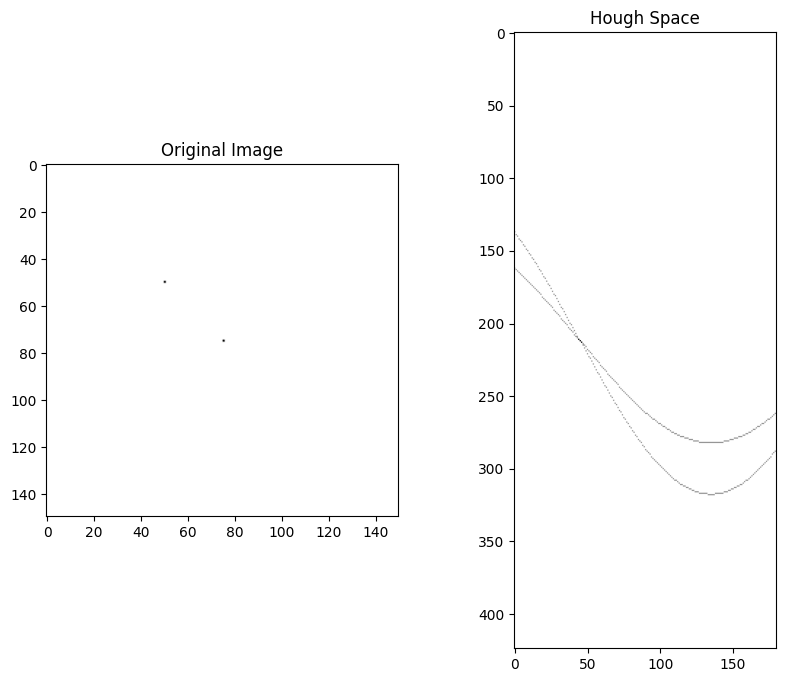

In [156]:
# Create an image with two points
image = np.zeros((150, 150))
image[75, 75] = 1
image[50, 50] = 1

# Apply the Hough Line transformation
accumulator, thetas, rhos = houghLine(image)

# Create plots for the original image and the Hough space
f, axarr = plt.subplots(1, 2, figsize=(10, 8))
axarr[0].title.set_text('Original Image')
axarr[0].imshow(image, cmap='Greys')
axarr[1].title.set_text('Hough Space')
axarr[1].imshow(accumulator, cmap='Greys')
plt.show()
